### <center>MSIN00143 Coursework Group N2

# <center>How does the COVID-19 pandemic affect the home advantage in the Premier League?

![alt text](https://static.independent.co.uk/2020/09/11/10/1269528787.jpg "Logo Title Text 1")

<center>Figure 1: Arsenal vs. Liverpool playing in the empty Wembley stadium

# Table of contents

* [1. Introduction](#1.-Introduction)
* [2. Import of dependencies](#2.-Import-of-dependencies)
* [3. Data collection and preperation](#3.-Data-collection-and-preperation)
* [4. Data exploration](#4.-Data-exploration)
    * [4.1 Change in home wins across teams](#4.1-Change-in-home-wins-across-teams)
    * [4.2 Change in home wins on team level](#4.2-Change-in-home-wins-on-team-level)
    * [4.3 Change of distribution of scorelines](#4.3-Change-of-distribution-of-scorelines)
    * [4.4 Significance test](#4.4-Significance-test)
* [5. Forecast model implementation](#5.-Forecast-model-implementation)
    * [5.1 Linear regression](#5.1-Linear-regression)
    * [5.2 Logistic regression](#5.2-Logistic-regression)
    * [5.3 Random forest](#5.3-Random-forest)
    * [5.4 Support vector classifier (SVC) model](#5.4-Support-vector-classifier-(SVC)-model)
    * [5.5 Naive bayes model](#5.5-Naive-bayes-model)
    * [5.6 Further model exploration](#5.6-Further-model-exploration)
* [6. Limitations](#6.-Limitations)
* [7. Conclusion](#7.-Conclusion)
* [I. Appendix](#I.-Appendix)

Wordcount : 2180

# 1. Introduction

Generally it is thought that playing in front of a home crowd is an advantage. 

The last English Premier League (EPL) game to be played in front of a crowd was on 9 March 2020.

The season resumed 100 days later, on 17 June. The remaining 92 games of the 2019/20 season, and all 117 games in the 2020/21 season down to the end of November 2020, have been played without a crowd present.

Our question is on whether playing at home without a crowd is still an advantage. We want to create predictive models based on past performances to see whether the results after COVID (AC) differ significantly results before COVID (BC).

The purpose of this paper is to try to create a scalable tool that could allow betting companies better to predict the outcome of football matches after COVID to maximise income and profit.

# 2. Import of dependencies

First we import the modules and codes we need to process and analyse the data.

In [11]:
!pip install pandas_profiling linearmodels pydot


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.



In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings; warnings.filterwarnings(action='once')
from datetime import datetime as dt
from patsy import dmatrix
from pydot import graph_from_dot_file
from scipy.stats import chi2_contingency, chi2
from IPython.display import Image
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.tree import export_graphviz

# 3. Data collection and preperation

Our data is from www.football-data.co.uk, for 2015 to date. We use data from 4 complete and unaffected BC seasons, one season with 288 BC games and 92 AC games, and the 117 AC games of the 2020/21 season down to 30 November 2020. The data set after deleting unnecessary columns is:

### Information of initial data set:

* **Date** = Match Date (dd/mm/yy)
* **HomeTeam** = Home Team
* **AwayTeam** = Away Team
* **FTHG** = Full Time Home Team Goals
* **FTAG** = Full Time Away Team Goals
* **FTR** = Full Time Result (H=Home Win, D=Draw, A=Away Win)

Next, we define a full list of features which will be used to train our predictive models. 

### Feature definition:

* **HTGD** (Home team goal difference)
* **ATGD** (Away team goal difference)
* **DiffFormPts** (Difference in form points)
* **DiffPts** (Difference in points)
* **HTWinStreak4** (Home team 4 win streak)
* **HTWinStreak3** (Home team 3 win streak)
* **ATWinStreak4** (Away team 4 win streak)
* **ATWinStreak3** (Away team 3 win streak)
* **HTLossStreak4** (Home team 4 loss streak)
* **HTLossStreak3** (Home team 3 loss streak)
* **ATLossStreak4** (Away team 4 loss streak)
* **ATLossStreak3** (Away team 3 loss streak)
* **DiffLP** (Difference in last year's standing)

A supporting file (EPLStandings.csv), which includes information about season rankings, is used to obtain basis data for the last feature DiffLP. A detailed overview of the feature list is provided in the **appendix**.

### Key steps in data transformation:

The information below provides a brief summary of the key steps in the data transformation process for creating the features. Detailed steps are shown in the next section. An overview of the columns of the final data set is provided in the **appendix**.

1. **Getting HTGD and ATGD:** 
    * 1a. Goals scored: Creating column for cumulative sum of goals scored for Home Team and Away Team respectively 
    * 1b. Goals conceded: Creating column for cumulative sum of goals conceded for Home Team and Away Team respectively 
    * 1c. Creating column that takes the difference between column Goals scored and Goals conceded
    
    
2. **Getting DiffFormPts:**
    * 2a. Creating supporting columns for recording the previous game performances for both Home Team and Away Team
     (e.g. for Home Team: "HM1" = last game, ..., "HM4" = fourth last game)
    * 2b. Creating summarizing string colums (e.g. "DDWW") and corresponding numeric columns
      for both Teams (e.g. 6)
    * 2c. Creating column that takes the difference between the Home Team's and Away Team's numeric summary column
    
    
3. **Getting DiffPts:**
    * 3a. Creating column to calculate cumulative sum of match points earned to date for both Home and Away Team
    * 3b. Creating column that takes the difference between cumulative match points of Home Team and Away Team
    
    
4. **Getting Streaks:**
    * 4a. Using logical operators based on summary string columns to assess whether certain for given streak is met


5. **Getting DiffLP:**
    * 5a. Adding supporting file to the data set, in which last year's standings are visible. Teams that play in the Premier League in     the t season but did not play in the Premier League in the t-1 season before get the ranking value 19 (represents last place)

### Step-by-step data transformation process

In [13]:
# Define years to be included in analysis
years = {
    '15': '1516',
    '16': '1617', 
    '17': '1718',
    '18': '1819',
    '19': '1920',
    '20': '2021'
}

raw_data = []

def parse_date(date):
    """
    Returns a datetime.date object given a date string
    """
    if date == '':
        return None
    else:
        try:
            return dt.strptime(date, '%d/%m/%y').date()
        except:
            return dt.strptime(date, '%d/%m/%Y').date()

# Loop to retrieve English Premier league results by match for years defined above and store them in raw_data list
for v in years.values():
    year_data = pd.read_csv(f'http://football-data.co.uk/mmz4281/{v}/E0.csv')
    year_data['Date'] = year_data['Date'].apply(parse_date)
    raw_data.append(year_data)
    
# Define columns needed (Date of match, home team name, away team name, full time home team goals, full time away team goals, full time result)
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']

# create list of playing statistics with columns needed
playing_stats = []
for df in raw_data:
    playing_stats.append(df[columns_req])


In [14]:
# Define dictionary of names to consolidate between data sources
names_replace = {
    'Manchester United': 'Man United',
    'West Ham United': 'West Ham',
    'Leicester City': 'Leicester',
    'Newcastle United': 'Newcastle',
    'Swansea City': 'Swansea',
    'Norwich City': 'Norwich',
    'Hull City': 'Hull',
    'Swansea City': 'Swansea',
    'Cardiff City': 'Cardiff',
    'Tottenham Hotspur': 'Tottenham',
    'Swansea City': 'Swansea',
    'Brighton & Hove Albion': 'Brighton',
    'Wolverhampton Wanderers': 'Wolves',
    'Stoke City': 'Stoke',
    'West Bromwich Albion': 'West Brom',
    'Manchester City': 'Man City',
    'Huddersfield Town': 'Huddersfield',
    'AFC Bournemouth': 'Bournemouth'
}

# Read in the end of season league positions for years in analysis - 1  
standings = pd.read_csv("/project/EPLStandings.csv")

# Replace team names with ones used in other data source
standings = standings.replace({'Team': names_replace})

# Create a list of all the team names that occur across all seasons in analysis
team_names_basedata = []
for df in playing_stats:
    team_names_basedata.append(df['HomeTeam'].unique())

# Create a unique list of all teams from standings data
team_names_basedata = np.concatenate(team_names_basedata).ravel()
team_names_basedata = np.unique(team_names_basedata).tolist()
team_names_standings = standings['Team'].unique().tolist()

# checking how many of teams of last year standings are not in basedata
for x in team_names_standings:
    if x not in team_names_basedata:
        print(x)

Queens Park Rangers


In [15]:
# Get the goals scored agg arranged by teams and matchweek
def get_goals_scored(playing_stat, game_weeks):
    """
    Function to return the goals scored by teams and game weeks
    Args:
        playing_stat: DataFrame of a year's worth of game data
        game_weeks: Number of completed game weeks in playing_stat
    Returns:
        List of goals scored in that year by game week
    """
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    if game_weeks != 38:
        game_weeks -= 1
        for team, results in teams.items():
            teams[team] = results[:game_weeks]
    # teams with lowest value (length of list, then minimum)
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1, game_weeks + 1)]).T
    GoalsScored[0] = 0
    # Aggregate to get uptil that point
    for i in range(2, game_weeks + 1):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored


# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat, game_weeks):
    """
    Function to return the goals conceded by teams and game weeks
    Args:
        playing_stat: DataFrame of a year's worth of game data
        game_weeks: Number of completed game weeks in playing_stat
    Returns:
        List of goals conceded in that year by game week
    """
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)
    
    if game_weeks != 38:
        game_weeks -= 1
        for team, results in teams.items():
            teams[team] = results[:game_weeks]
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1, game_weeks + 1)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(2, game_weeks + 1):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded
    

def get_gss(playing_stat, game_weeks):
    """
    Function to return the goals data for each team throughout a season
    Args:
        playing_stat: DataFrame of a year's worth of game data
        game_weeks: Number of completed game weeks in playing_stat
    Returns:
        DataFrame with each team's goals scored and goals conceeded throughout season
    """
    GC = get_goals_conceded(playing_stat, game_weeks)
    GS = get_goals_scored(playing_stat, game_weeks)  
    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(game_weeks * 10):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])
        
        if ((i + 1)% 10) == 0:
            j = j + 1
        
    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC
    
    return playing_stat


def get_points(result):
    """
    Function to return the points attibutable to result
    Args:
        result: String representation of W(in), L(ose), or D(raw)
    Returns:
        Int of points won
    """
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0
    

def get_cuml_points(matchres):
    """
    Function to add cumulative sum of points 
    Args:
        matchres: DataFrame of a year's worth match results
    Returns:
        DataFrame with cumulative points added as a column
    """
    matchres_points = matchres.applymap(get_points)
    matchres_points = matchres_points.cumsum(axis=1)
    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    print(matchres_points)
    return matchres_points


def get_matchres(playing_stat, return_dict=False):
    """
    Function to add match results as a cumulative to DataFrame
    Args:
        playing_stat: DataFrame of a year's worth of game data
        return_dict: Optional. To return a dictionary of results rather than DataFrame
    Returns:
        DataFrame with match results for the season OR dictionary object of teams results
    """
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')
    if return_dict:
        return teams
    min_val = min([len(teams[list]) for list in teams])
    teams = {team:value[:min_val - 1] for (team, value) in teams.items()}
    return pd.DataFrame(data=teams, index = [i for i in range(1, min_val)]).T


def get_agg_points(playing_stat, game_weeks):
    """
    Function to return the aggregated points for each team throughout a season
    Args:
        playing_stat: DataFrame of a year's worth of game data
        game_weeks: Number of completed game weeks in playing_stat
    Returns:
        DataFrame with each team's aggregated points total throughout season
    """
    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(game_weeks * 10):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])
        if ((i + 1)% 10) == 0 and j < cum_pts.shape[1] - 1:
            j += 1
            
    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat


def get_form(playing_stat, num, game_weeks):
    """
    Function to return the team's form throughout a season
    Args:
        playing_stat: DataFrame of a year's worth of game data
        # num: <- look into this <-
        game_weeks: Number of completed game weeks in playing_stat
    Returns:
        DataFrame with each team's form throughout season
    """
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num, form_final.shape[1]):
        form_final[i] = ''
        j = 0
        while j < num and j < form_final.shape[1]:
            form_final[i] += form[i-j]
            j += 1           
    return form_final


def get_last(playing_stat, standings, year):
    """
    Function to return the team's league positions from the previous season
    Args:
        playing_stat: DataFrame of a year's worth of game data
        standings: DataFrame of final league positions over many years
        year: int of year to be added
    Returns:
        DataFrame with each team's goals scored and goals conceeded throughout season
    """
    standing_year = standings[standings['Year'] == year]
    standing_year.set_index('Team', inplace=True)
    playing_stat['HomeTeamLP'] = playing_stat['HomeTeam'].map(standing_year['Standing']).fillna(19)
    playing_stat['AwayTeamLP'] = playing_stat['AwayTeam'].map(standing_year['Standing']).fillna(19)
    return playing_stat


def add_form(playing_stat, num, game_weeks):
    """
    Function to add form as columns to the season's data
    Args:
        playing_stat: DataFrame of a year's worth of game data
        num: Number of previous games to calculate form for 
        game_weeks: Number of completed game weeks in playing_stat
    Returns:
        DataFrame with each team's previous x games form
    """
    form = get_form(playing_stat, num, game_weeks)
    h = ['M' for i in range(num * 10)]  # since form is not available for n MW (n*10)
    a = ['M' for i in range(num * 10)]
    j = num
    for i in range((num*10), game_weeks * 10):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        past = form.loc[ht][j]
        try:
            h.append(past[num-1])
        except IndexError:
            h.append('M')                  # 0 index is most recent
        
        past = form.loc[at][j]               # get past n results.
        try:
            a.append(past[num-1])                   # 0 index is most recent
        except IndexError:
            a.append('M')                  # 0 index is most recent
        
        if ((i + 1)% 10) == 0 and j < form.shape[1]:
            j = j + 1

    playing_stat['HM' + str(num)] = h                 
    playing_stat['AM' + str(num)] = a

    
    return playing_stat


def get_completed_match_weeks(df):
    """
    Function to calcuate minumum games completed by any team in the league (used as proxy for games weeks completed)
    Args:
        df: DataFrame of a year's worth of game data
    Returns:
        Int of minimum games completed by any team
    """
    
    # if the season is complete then 38 game weeks are complete
    if df.shape[0] == 380:
        return 38
    
    # get the match results
    results = get_matchres(df, return_dict=True)
    # select the minimum value of results for any team
    min_games_played = min([len(n) for n in results.values()])
    return min_games_played


# Identify Win/Loss Streaks if any.
def get_3game_ws(string):
    """
    Function to identify a 3 game winning streak 
    Args:
        string: string of result values
    Returns:
        boolean if 3 game winning streak
    """    
    if string[-3:] == 'WWW':
        return 1
    else:
        return 0

    
def get_4game_ws(string):
    """
    Function to identify a 4 game winning streak 
    Args:
        string: string of result values
    Returns:
        boolean if 4 game winning streak
    """    
    if string == 'WWWW':
        return 1
    else:
        return 0

    
def get_3game_ls(string):
    """
    Function to identify a 3 game losing streak 
    Args:
        string: string of result values
    Returns:
        boolean if 3 game losing streak
    """    
    if string[-3:] == 'LLL':
        return 1
    else:
        return 0

    
def get_4game_ls(string):
    """
    Function to identify a 4 game losing streak 
    Args:
        string: string of result values
    Returns:
        boolean if 4 game losing streak
    """    
    if string == 'LLLL':
        return 1
    else:
        return 0

    
# Gets the form points.
def get_form_points(string):
    """
    Function to calculate points value based off string of WLD values
    Args:
        string: string of result values
    Returns:
        Sum of points values of all letters of string
    """    
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

In [16]:
# Define columns with all columns engineered
cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
        'HM4', 'AM1', 'AM2', 'AM3', 'AM4', 'HomeTeamLP', 'AwayTeamLP']

# create empty DataFrame
play_stats_concat = pd.DataFrame()

# Loop through individual years results and populate all data DataFrame with engineered columns for given years
for year, df in enumerate(playing_stats, start=2014):
    match_weeks = get_completed_match_weeks(df)
    df = df.head(match_weeks * 10)
    df = get_gss(df, match_weeks)
    df = get_agg_points(df, match_weeks)
    for count in range(1, 5): 
        df = add_form(df, count, match_weeks)
    df = get_last(df, standings, year)
    df = df[cols]
    play_stats_concat = play_stats_concat.append(df)


<ipython-input-15-69514169bf22>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTGS'] = HTGS


                0   1   2   3   4   5   6   7   8   9   ...  28  29  30  31  \
Arsenal          0   0   3   4   7  10  10  13  16  19  ...  51  52  55  58   
Aston Villa      0   3   3   3   4   4   4   4   4   4  ...  16  16  16  16   
Bournemouth      0   0   0   3   4   4   7   7   8   8  ...  32  35  38  38   
Chelsea          0   1   1   4   4   4   7   8   8  11  ...  39  40  41  44   
Crystal Palace   0   3   3   6   9   9   9  12  15  15  ...  33  33  33  34   
Everton          0   1   4   4   5   8   9  12  13  13  ...  38  38  38  39   
Leicester        0   3   6   7   8  11  12  12  15  16  ...  57  60  63  66   
Liverpool        0   3   6   7   7   7   8  11  12  13  ...  44  44  45  48   
Man City         0   3   6   9  12  15  15  15  18  21  ...  50  51  51  54   
Man United       0   3   6   7   7  10  13  16  16  19  ...  47  47  50  53   
Newcastle        0   1   1   2   2   2   2   3   3   6  ...  24  24  25  25   
Norwich          0   0   3   4   4   7   8   9   9  

<ipython-input-15-69514169bf22>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP


                0   1   2   3   4   5   6   7   8   9   ...  28  29  30  31  \
Arsenal          0   0   1   4   7  10  13  16  19  20  ...  51  54  54  57   
Bournemouth      0   0   0   1   4   4   7   8  11  12  ...  30  33  34  35   
Burnley          0   0   3   3   4   4   7   7   7  10  ...  31  32  32  35   
Chelsea          0   3   6   9  10  10  10  13  16  19  ...  69  69  72  75   
Crystal Palace   0   0   0   1   4   7  10  11  11  11  ...  28  31  31  34   
Everton          0   1   4   7  10  13  13  14  15  15  ...  47  50  50  51   
Hull             0   3   6   6   7   7   7   7   7   7  ...  24  24  27  30   
Leicester        0   0   1   4   4   7   7   8   8  11  ...  30  33  36  36   
Liverpool        0   3   3   4   7  10  13  16  17  20  ...  55  56  59  60   
Man City         0   3   6   9  12  15  18  18  19  20  ...  57  58  58  61   
Man United       0   3   6   9   9   9  12  13  14  14  ...  53  54  57  60   
Middlesbrough    0   1   4   5   5   5   5   6   6  

<ipython-input-15-69514169bf22>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP


                0   1   2   3   4   5   6   7   8   9   ...  28  29  30  31  \
Arsenal          0   3   3   3   6   7  10  13  13  16  ...  45  45  48  51   
Bournemouth      0   0   0   0   0   3   3   4   4   7  ...  32  33  33  36   
Brighton         0   0   0   1   4   4   7   7   8  11  ...  31  34  34  34   
Burnley          0   3   3   4   7   8   9  12  13  13  ...  37  40  43  46   
Chelsea          0   0   3   6   9  10  13  13  13  16  ...  53  53  56  56   
Crystal Palace   0   0   0   0   0   0   0   0   3   3  ...  27  27  27  30   
Everton          0   3   4   4   4   4   7   7   8   8  ...  34  34  37  40   
Huddersfield     0   3   6   7   7   8   9   9   9  12  ...  30  30  31  31   
Leicester        0   0   3   3   3   4   4   5   6   9  ...  36  37  40  43   
Liverpool        0   1   4   7   7   8  11  12  13  13  ...  57  60  60  63   
Man City         0   3   4   7  10  13  16  19  22  25  ...  75  78  81  84   
Man United       0   3   6   9  10  13  16  19  20  

<ipython-input-15-69514169bf22>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP


                0   1   2   3   4   5   6   7   8   9   ...  28  29  30  31  \
Arsenal          0   0   0   3   6   9  12  15  18  21  ...  56  57  60  63   
Bournemouth      0   3   6   7   7  10  10  13  16  17  ...  34  34  37  38   
Brighton         0   0   3   3   4   5   5   5   8  11  ...  30  33  33  33   
Burnley          0   1   1   1   1   1   4   7   8   8  ...  30  30  30  30   
Cardiff          0   0   1   2   2   2   2   2   2   5  ...  25  25  28  28   
Chelsea          0   3   6   9  12  15  16  17  20  21  ...  56  57  57  60   
Crystal Palace   0   3   3   3   3   6   7   7   7   7  ...  30  33  33  36   
Everton          0   1   4   5   6   6   6   9  12  15  ...  36  37  37  40   
Fulham           0   0   0   3   4   4   5   5   5   5  ...  17  17  17  17   
Huddersfield     0   0   0   1   2   2   2   2   3   3  ...  14  14  14  14   
Leicester        0   0   3   6   6   6   9  12  12  12  ...  35  35  38  41   
Liverpool        0   3   6   9  12  15  18  19  20  

<ipython-input-15-69514169bf22>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP


                  0   1   2   3   4   5   6   7   8   9   ...  28  29  30  31  \
Arsenal            0   3   6   6   7   8  11  12  15  15  ...  40  40  40  43   
Aston Villa        0   0   0   3   3   4   4   5   8  11  ...  25  26  26  27   
Bournemouth        0   1   4   4   4   7  10  11  11  12  ...  27  27  27  27   
Brighton           0   3   4   4   4   5   6   6   9   9  ...  28  29  32  33   
Burnley            0   3   3   4   4   5   8   9  12  12  ...  38  39  39  42   
Chelsea            0   0   1   4   5   8   8  11  14  17  ...  45  48  51  54   
Crystal Palace     0   1   1   4   7   7   8  11  14  14  ...  36  39  42  42   
Everton            0   1   4   4   7   7   7   7   7  10  ...  37  37  38  41   
Leicester          0   1   2   5   8   8  11  14  14  17  ...  50  53  54  55   
Liverpool          0   3   6   9  12  15  18  21  24  25  ...  79  82  83  86   
Man City           0   3   4   7  10  10  13  16  16  19  ...  57  60  63  63   
Man United         0   3   4

<ipython-input-15-69514169bf22>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP


                  0  1  2  3   4   5   6   7   8
Arsenal           0  3  6  6   9   9   9  12  12
Aston Villa       0  3  6  9  12  12  12  15  15
Brighton          0  0  3  3   3   4   5   5   6
Burnley           0  0  0  0   1   1   1   2   5
Chelsea           0  3  3  4   7   8   9  12  15
Crystal Palace    0  3  6  6   6   7  10  10  13
Everton           0  3  6  9  12  13  13  13  13
Fulham            0  0  0  0   0   1   1   4   4
Leeds             0  0  3  6   7   7  10  10  10
Leicester         0  3  6  9   9   9  12  15  18
Liverpool         0  3  6  9   9  10  13  16  17
Man City          0  3  3  4   7   8  11  12  12
Man United        0  0  3  3   6   7   7  10  13
Newcastle         0  3  3  4   7   7   8  11  11
Sheffield United  0  0  0  0   0   1   1   1   1
Southampton       0  0  0  3   6   7  10  13  16
Tottenham         0  0  3  4   7   8  11  14  17
West Brom         0  0  0  1   1   2   3   3   3
West Ham          0  0  0  3   6   7   8   8  11
Wolves            0 

<ipython-input-15-69514169bf22>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP


In [17]:

# Create form string based on previous 4 game results for home and away team
play_stats_concat['HTFormPtsStr'] = play_stats_concat['HM1'] + play_stats_concat['HM2'] + play_stats_concat['HM3'] + play_stats_concat['HM4']
play_stats_concat['ATFormPtsStr'] = play_stats_concat['AM1'] + play_stats_concat['AM2'] + play_stats_concat['AM3'] + play_stats_concat['AM4']

# Create points value for form string for home and away teams
play_stats_concat['HTFormPts'] = play_stats_concat['HTFormPtsStr'].apply(get_form_points)
play_stats_concat['ATFormPts'] = play_stats_concat['ATFormPtsStr'].apply(get_form_points)
    
# Create winning/losing streak columns for home and away teams
play_stats_concat['HTWinStreak3'] = play_stats_concat['HTFormPtsStr'].apply(get_3game_ws)
play_stats_concat['HTWinStreak4'] = play_stats_concat['HTFormPtsStr'].apply(get_4game_ws)
play_stats_concat['HTLossStreak3'] = play_stats_concat['HTFormPtsStr'].apply(get_3game_ls)
play_stats_concat['HTLossStreak4'] = play_stats_concat['HTFormPtsStr'].apply(get_4game_ls)

play_stats_concat['ATWinStreak3'] = play_stats_concat['ATFormPtsStr'].apply(get_3game_ws)
play_stats_concat['ATWinStreak4'] = play_stats_concat['ATFormPtsStr'].apply(get_4game_ws)
play_stats_concat['ATLossStreak3'] = play_stats_concat['ATFormPtsStr'].apply(get_3game_ls)
play_stats_concat['ATLossStreak4'] = play_stats_concat['ATFormPtsStr'].apply(get_4game_ls)

# Get Goal Difference
play_stats_concat['HTGD'] = play_stats_concat['HTGS'] - play_stats_concat['HTGC']
play_stats_concat['ATGD'] = play_stats_concat['ATGS'] - play_stats_concat['ATGC']

# Diff in points
play_stats_concat['DiffPts'] = play_stats_concat['HTP'] - play_stats_concat['ATP']
play_stats_concat['DiffFormPts'] = play_stats_concat['HTFormPts'] - play_stats_concat['ATFormPts']

# Diff in last year positions
play_stats_concat['DiffLP'] = play_stats_concat['HomeTeamLP'] - play_stats_concat['AwayTeamLP']
play_stats_concat['Date'] = pd.to_datetime(play_stats_concat['Date'])

In [18]:
# Create data frame and limit to before the limited return of crowds (2nd December 2020)
df = play_stats_concat[play_stats_concat['Date'] < pd.Timestamp(2020, 12, 1)]

# 4. Data exploration

Our primary target is to look at the changes in the number of home wins (H), draws (D), and away wins (A) between the BC and AC periods. First, we want to analyse the changes across teams.

# 4.1 Change in home wins across teams

In [19]:
# distinguish between before and after COVID period
df['datetime'] = pd.to_datetime(df['Date'])

full_result = {'H': 'Home win', 'A': 'Away win', 'D': 'Draw'}
df['verbose_result'] = df.apply(lambda row: full_result[row['FTR']], axis=1)

bc = df[df['datetime'] < pd.Timestamp(2020,3,12)]
post_lockdown = df[df['datetime'] > pd.Timestamp(2020,3,12)]




<ipython-input-19-ea2bbc2c0fb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['Date'])


Text(0, 0.5, 'Games played')

[]

Text(0.0, 45.94115044247788, '45.74%')

Text(1.0, 30.50973451327434, '30.31%')

Text(2.0, 24.149115044247786, '23.95%')

Text(0, 0.5, 'Games played')

[]

Text(0.0, 41.77894736842106, '41.58%')

Text(1.0, 38.09473684210527, '37.89%')

Text(2.0, 20.726315789473684, '20.53%')

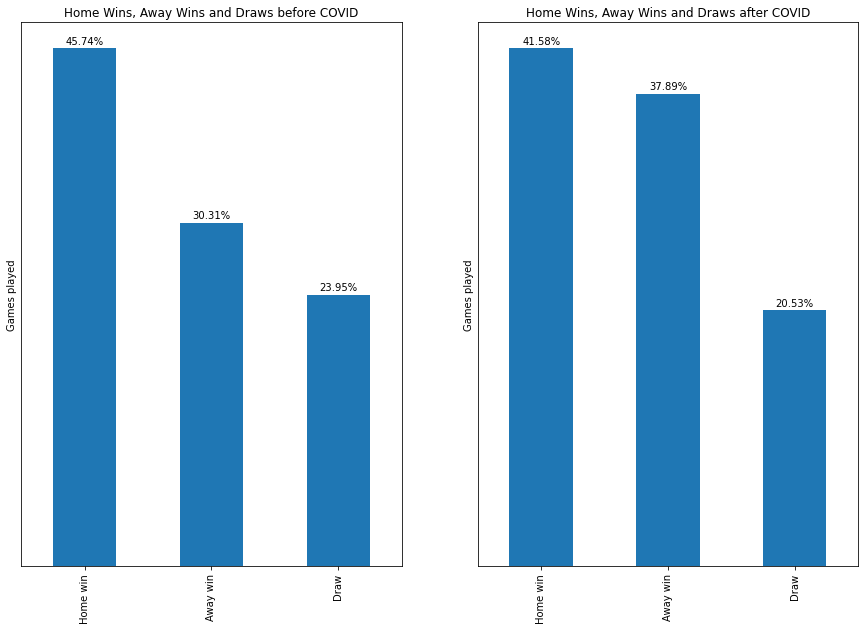

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

bc['verbose_result'].value_counts(normalize=True).apply(lambda x: x * 100).plot.bar(legend=False, ax=ax1, title='Home Wins, Away Wins and Draws before COVID')
ax1.set_ylabel('Games played')
ax1.get_yaxis().set_ticks([])

rects = ax1.patches

labels_1 = bc['verbose_result'].value_counts(normalize=True).apply(lambda x: x * 100)

for rect, label in zip(rects, labels_1):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.2, str(round(label, 2)) + '%',
            ha='center', va='bottom')
post_lockdown['verbose_result'].value_counts(normalize=True).apply(lambda x: x * 100).plot.bar(legend=False, ax=ax2, title='Home Wins, Away Wins and Draws after COVID')
ax2.set_ylabel('Games played')

ax2.get_yaxis().set_ticks([])
rects = ax2.patches

labels_2 = post_lockdown['verbose_result'].value_counts(normalize=True).apply(lambda x: x * 100)

for rect, label in zip(rects, labels_2):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 0.2, str(round(label, 2)) + '%',
            ha='center', va='bottom')

### Interpretation

These graphs show that there is a noticeable change in the proportions of home wins and away wins, with the proportion of draws staying roughly the same.

# 4.2 Change in home wins on team level

In [21]:
# ----------- DATA MANIPULATION FOR SUBSET BEFORE COVID ---------------

# create slice of season up to COVID to get recent form only to compare to
bc_1920 = bc[bc['datetime'] > pd.Timestamp(2019, 7, 15)]

# calculate number home wins 
df_temp_1 = bc_1920[bc_1920['FTR'] == 'H'].groupby('HomeTeam').count()

# calculate number of total home games `
df_temp_2 = bc_1920.groupby('HomeTeam').count()

# extract created columns to new dataframe
df_1 = df_temp_1[["FTR"]]
df_1 = df_1.rename(columns={'FTR': 'home_wins'})
df_2 = df_temp_2[["FTR"]]
df_2 = df_2.rename(columns={'FTR': 'home_games'})

# merge dataframes together
df_final = pd.concat([df_1, df_2], axis=1)

# calculate percentage of home wins
df_final['%_of_home_wins'] = round((df_final['home_wins'] / df_final['home_games'])*100, 2)
#df_final.sort_index()

# ----------- DATA MANIPULATION FOR SUBSET AFTER COVID ---------------

# calculate number home wins 
df_temp_post_1 = post_lockdown[post_lockdown['FTR'] == 'H'].groupby('HomeTeam').count()

# calculate number of total home games 
df_temp_post_2 = post_lockdown.groupby('HomeTeam').count()

# extract created columns to new dataframe
df_post_1 = df_temp_post_1[["FTR"]]
df_post_1 = df_post_1.rename(columns={'FTR': 'home_wins'})
df_post_2 = df_temp_post_2[["FTR"]]
df_post_2 = df_post_2.rename(columns={'FTR': 'home_games'})

df_post_final = pd.concat([df_post_1, df_post_2], axis=1)
df_post_final['%_of_home_wins_after'] = round((df_post_final['home_wins'] / df_post_final['home_games'])*100, 2)
#df_post_final.sort_index()

# Teams with NaN values did not win matches yet. We replace NaN by 0.
df_post_final['home_wins'] = df_post_final['home_wins'].fillna(0)
df_post_final['%_of_home_wins_after'] = df_post_final['%_of_home_wins_after'].fillna(0)

# ----------- MERGE TWO SUBSETS TOGETHER ---------------

# merge
df_comparison = pd.concat([df_final, df_post_final], axis=1)

# rename column
df_comparison.rename(columns={'%_of_home_wins': '%_of_home_wins_before'}, inplace=True)

# drop unnecessary columns
df_comparison.drop(columns=['home_wins', 'home_games'], inplace = True)

# create column to calculate change between before and after COVID
df_comparison['evolution'] = df_comparison['%_of_home_wins_after'] - df_comparison['%_of_home_wins_before'] 
df_comparison = df_comparison.sort_values(by='evolution', ascending=True)

# we get NaN values since before COVID period has more unique teams. We exclude those as they do not play in the current season
df_comparison.dropna(inplace=True)

# add column to label whether home wins have decreased (if evolution is negative = 1, if positive = 0)
df_comparison['home_wins_decreased'] = np.where(df_comparison['evolution'] < 0, 1, 0)

# showing table with percentage number of home wins before and after corona 
df_comparison

# reporting number of teams for which home wins have decreased
print("Number of teams for which home wins have decreased:", sum(df_comparison['home_wins_decreased']))

# reporting number of teams for which home wins have increased
print("Number of teams for which home wins have increased:", 20 - sum(df_comparison['home_wins_decreased']))

,%_of_home_wins_before,%_of_home_wins_after,evolution,home_wins_decreased
Norwich,28.57,0.00,-28.57,1
Burnley,46.67,25.00,-21.67,1
Everton,50.00,30.00,-20.00,1
Man United,53.33,33.33,-20.00,1
Brighton,28.57,10.00,-18.57,1
Crystal Palace,40.00,22.22,-17.78,1
Leicester,60.00,44.44,-15.56,1
Sheffield United,46.67,33.33,-13.34,1
Liverpool,100.00,88.89,-11.11,1
Bournemouth,28.57,20.00,-8.57,1


Number of teams for which home wins have decreased: 12
Number of teams for which home wins have increased: 8


### Creating corresponding visualization

<Figure size 1120x800 with 0 Axes>

[Text(0, 0.5, 'Teams'), Text(0.5, 0, 'Change in Home Wins')]

([<matplotlib.axis.YTick at 0x7fd6363cb400>,
 [Text(0, 0, 'Norwich'),
  Text(0, 0, 'Burnley'),
  Text(0, 0, 'Everton'),
  Text(0, 0, 'Man United'),
  Text(0, 0, 'Brighton'),
  Text(0, 0, 'Crystal Palace'),
  Text(0, 0, 'Leicester'),
  Text(0, 0, 'Sheffield United'),
  Text(0, 0, 'Liverpool'),
  Text(0, 0, 'Bournemouth'),
  Text(0, 0, 'Newcastle'),
  Text(0, 0, 'Aston Villa'),
  Text(0, 0, 'Tottenham'),
  Text(0, 0, 'Arsenal'),
  Text(0, 0, 'Man City'),
  Text(0, 0, 'Watford'),
  Text(0, 0, 'Chelsea'),
  Text(0, 0, 'West Ham'),
  Text(0, 0, 'Wolves'),
  Text(0, 0, 'Southampton')])

Text(0.5, 1.0, 'Percentage change in home wins between before and after COVID period')

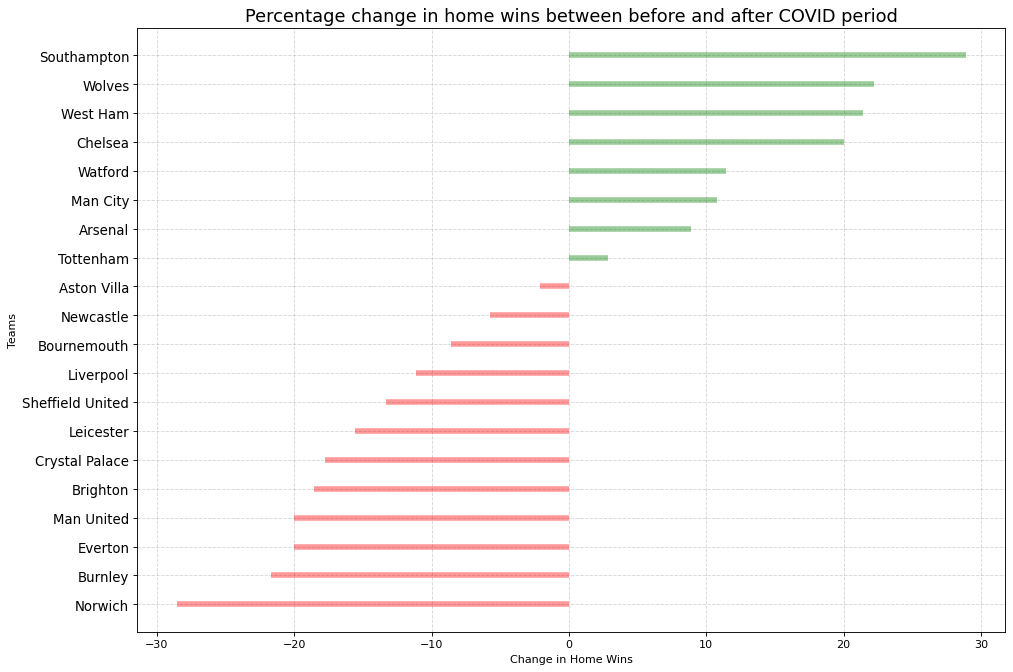

In [22]:
# preparing data
df_viz = df_comparison
df_viz['colors'] = ['red' if x == 1 else 'green' for x in df_viz['home_wins_decreased']]
df_viz.sort_values('evolution', inplace=True)

# drawing plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=df_viz.index, xmin=0, xmax=df_viz['evolution'], color=df_viz.colors, alpha=0.4, linewidth=5)

# decorations
plt.gca().set(ylabel='Teams', xlabel='Change in Home Wins')
plt.yticks(df_viz.index, df_viz.index, fontsize=12)
plt.title('Percentage change in home wins between before and after COVID period', fontdict={'size':16})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Interpretation

The percentage of home wins has decreased for **12 out of 20 teams** (red bars) after COVID, which appears to indicate an effect of the closure of stadiums on the home advantage. However, the observed time period after COVID is very short and there are many games left to play in the current season of 2020/21.

# 4.3 Change of distribution of scorelines

Text(0.5, 0, 'Home Team Goals Scored')

Text(0, 0.5, 'Away Team Goals Scored')

Text(0.5, 0, 'Home Team Goals Scored')

Text(0, 0.5, 'Away Team Goals Scored')

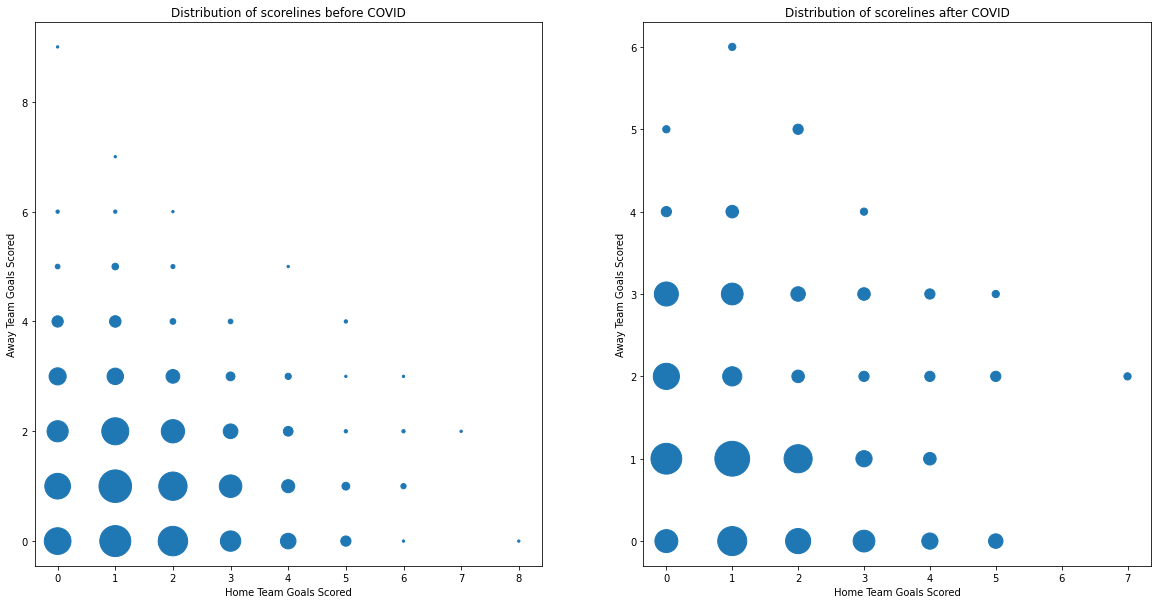

In [23]:
# Create plots to show the distribution of scorelines before and after COVID
before_scores = bc[['FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).size().to_frame(name = 'occurances').reset_index()
before_scores['proportion'] = before_scores['occurances'] / sum(before_scores['occurances']) * 10000
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10)) 
before_scores.plot(kind='scatter', x='FTHG', y='FTAG', s=before_scores['proportion'], ax=ax1, title=('Distribution of scorelines before COVID'))
ax1.set_xlabel('Home Team Goals Scored')
ax1.set_ylabel('Away Team Goals Scored')

after_scores = post_lockdown[['FTHG', 'FTAG']].groupby(['FTHG', 'FTAG']).size().to_frame(name = 'occurances').reset_index()
after_scores['proportion'] = after_scores['occurances'] / sum(after_scores['occurances']) * 10000
after_scores.plot(kind='scatter', x='FTHG', y='FTAG', s=after_scores['proportion'], ax=ax2, title=('Distribution of scorelines after COVID'))
ax2.set_xlabel('Home Team Goals Scored')
ax2.set_ylabel('Away Team Goals Scored')


### Interpretation

The size of each circle indicates the relative frequency of each result. Note that there are many fewer games after COVID, so for example the dot for 7-2 is for just one game. Again these show a noticeable change, with a greater proportion of higher scoring results away from a concentration before COVID towards lower scoring results.

# 4.4 Significance test

In [24]:
# Statistically test whether the change in results is significant

comparison_freq = pd.concat([bc['verbose_result'].value_counts(), post_lockdown['verbose_result'].value_counts()], axis=1)
comparison_freq.columns=['Total BC', 'Total AC']
comparison_freq
stat, p, dof, expected = chi2_contingency(comparison_freq)
stat, p, dof, expected
prob = 0.95
critical = chi2.ppf(prob, dof)
critical

,Total BC,Total AC
Home win,827,79
Away win,548,72
Draw,433,39


(4.697168787012517,
 0.09550426302311373,
 2,
 array([[819.84384384,  86.15615616],
        [561.04104104,  58.95895896],
        [427.11511512,  44.88488488]]))

5.991464547107979

### Interpretation

The table above shows the total number of each results during the BC and AC periods. The key statistical output is the p value, which is 0.096. This is a high p value, which means that the change from BC to AC is not statistically significant.

# 5. Forecast model implementation

We tested 5 models on various aspects of the data to ascertain which worked best to predict the AC results.

The models we chose to test are

- Linear regression
- Logistic regression
- Random forest
- SVC model
- Naive Bayes

In order to prepare the data for modelling we split the data into before COVID and after COVID. As the change between the two is of interest we trained our models on before COVID data. We then selected the best performing model then assessed it against the before COVID data to assess whether the prediction coefficients have changed and whether the output could be used as an explanation of changes in results.

# 5.1 Linear regression

### Data preparation

In [25]:
# create a copy of the data to preserve the original data frame
data = df.copy()
# Drop the columns containing text
data = data.dropna(subset=['HomeTeamLP', 'AwayTeamLP'])
# create data frame based on before COVID (BC) data and after COVID data
bc = data[data['datetime'] < pd.Timestamp(2020,3,12)]
post_lockdown = data[data['datetime'] > pd.Timestamp(2020,3,12)]
# Describe the data frames <- note the differences in means and stds for the home and away goals between the dfs
bc.describe()
post_lockdown.describe()

,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HomeTeamLP,AwayTeamLP,...,HTLossStreak4,ATWinStreak3,ATWinStreak4,ATLossStreak3,ATLossStreak4,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
count,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,...,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000
mean,1.540929,1.204646,24.367257,24.427544,24.415376,24.324668,24.464049,24.554204,10.804204,10.809735,...,0.032633,0.068031,0.040929,0.058075,0.024889,-0.048119,0.102876,-0.090155,-0.193031,-0.005531
std,1.286981,1.186598,17.895041,17.871869,16.664419,16.640248,18.298479,18.201794,6.039837,6.041479,...,0.177723,0.251869,0.198181,0.233950,0.155831,16.134548,16.206315,15.342435,4.085123,8.738719
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-54.000000,-54.000000,-61.000000,-12.000000,-18.000000
25%,1.000000,0.000000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,5.750000,5.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,-9.000000,-7.000000,-3.000000,-7.000000
50%,1.000000,1.000000,22.000000,22.000000,23.000000,22.000000,21.000000,22.000000,11.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,35.000000,35.000000,36.000000,36.000000,35.000000,35.000000,17.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,6.250000,3.000000,6.250000
max,8.000000,9.000000,102.000000,105.000000,77.000000,76.000000,94.000000,97.000000,19.000000,19.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,76.000000,78.000000,74.000000,12.000000,18.000000


,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HomeTeamLP,AwayTeamLP,...,HTLossStreak4,ATWinStreak3,ATWinStreak4,ATLossStreak3,ATLossStreak4,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,...,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,1.478947,1.363158,25.205263,25.452632,25.652632,24.910526,24.689474,25.536842,10.973684,10.873684,...,0.036842,0.036842,0.010526,0.052632,0.031579,-0.447368,0.542105,-0.847368,-0.284211,0.100000
std,1.424309,1.276449,21.935812,22.043856,20.772778,20.160399,22.359577,23.173288,6.147597,6.144197,...,0.188872,0.188872,0.102326,0.223887,0.175338,16.597790,16.440877,15.794409,3.638894,8.907253
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-42.000000,-44.000000,-53.000000,-10.000000,-18.000000
25%,0.000000,0.000000,6.000000,6.000000,7.000000,8.000000,6.000000,5.000000,6.000000,5.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-8.000000,-7.000000,-3.000000,-6.750000
50%,1.000000,1.000000,18.500000,18.000000,16.000000,17.000000,16.500000,16.500000,11.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,38.000000,40.000000,44.750000,42.750000,42.000000,43.750000,17.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,4.000000,2.000000,7.000000
max,7.000000,6.000000,97.000000,93.000000,68.000000,70.000000,93.000000,96.000000,19.000000,19.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,62.000000,58.000000,59.000000,10.000000,18.000000


([<matplotlib.axis.XTick at 0x7fd62ffbac70>,
 [Text(0, 1, 'DiffLP'),
  Text(0, 1, 'DiffFormPts'),
  Text(0, 1, 'DiffPts'),
  Text(0, 1, 'HTWinStreak4'),
  Text(0, 1, 'ATWinStreak4'),
  Text(0, 1, 'HTLossStreak4'),
  Text(0, 1, 'ATLossStreak4')])

([<matplotlib.axis.YTick at 0x7fd62ffbe130>,
 [Text(0, 0, 'DiffLP'),
  Text(0, 0, 'DiffFormPts'),
  Text(0, 0, 'DiffPts'),
  Text(0, 0, 'HTWinStreak4'),
  Text(0, 0, 'ATWinStreak4'),
  Text(0, 0, 'HTLossStreak4'),
  Text(0, 0, 'ATLossStreak4')])

Text(0.5, 1.05, 'Correlation Matrix')

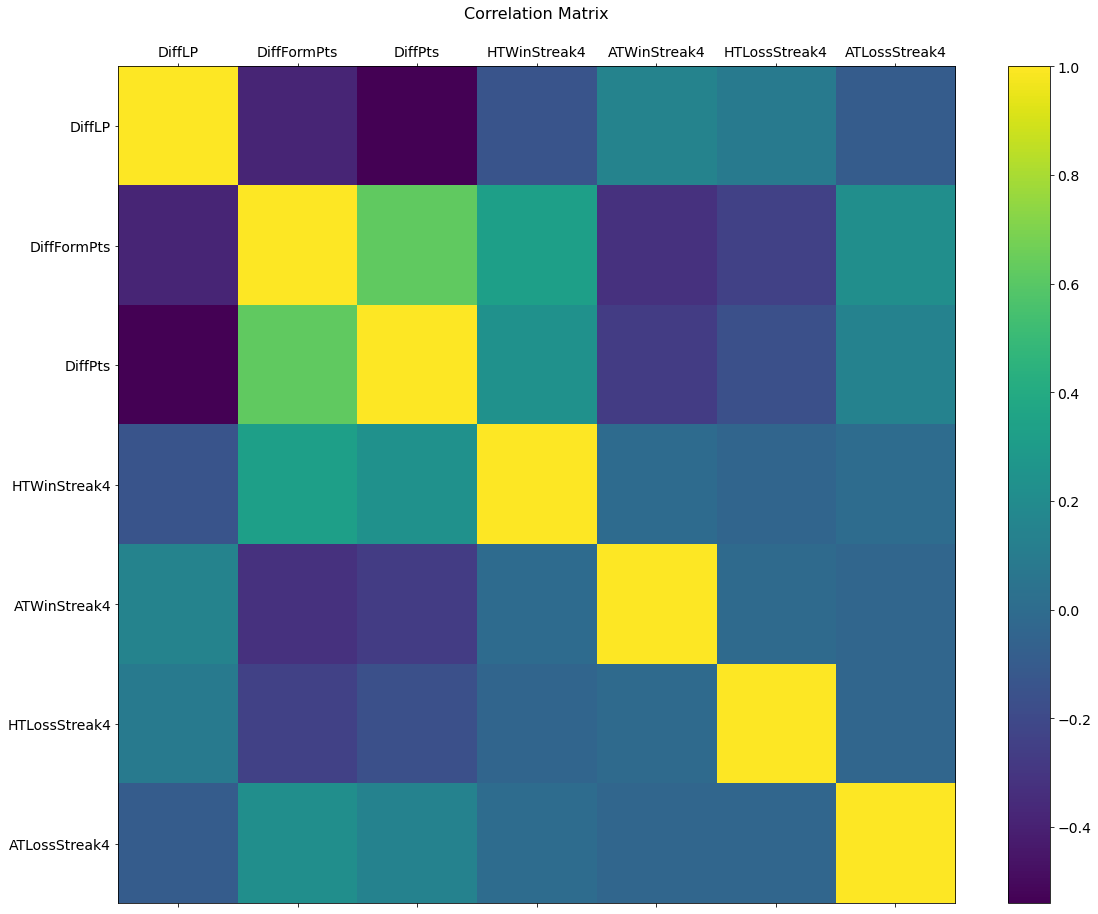

In [26]:
# Columns selected for model inclusion
cols_in_model = ['DiffLP', 'DiffFormPts', 'DiffPts', 'HTWinStreak4', 'ATWinStreak4', 'HTLossStreak4', 'ATLossStreak4']

f = plt.figure(figsize=(19, 15))
plt.matshow(bc[cols_in_model].corr(), fignum=f.number)
plt.xticks(range(bc[cols_in_model].shape[1]), bc[cols_in_model].columns, fontsize=14)
plt.yticks(range(bc[cols_in_model].shape[1]), bc[cols_in_model].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# DiffPts is highly correlated with DiffLP and so will be removed from the model
cols_in_model = ['DiffLP', 'DiffFormPts', 'HTWinStreak4', 'ATWinStreak4', 'HTLossStreak4', 'ATLossStreak4']

### Try linear regression

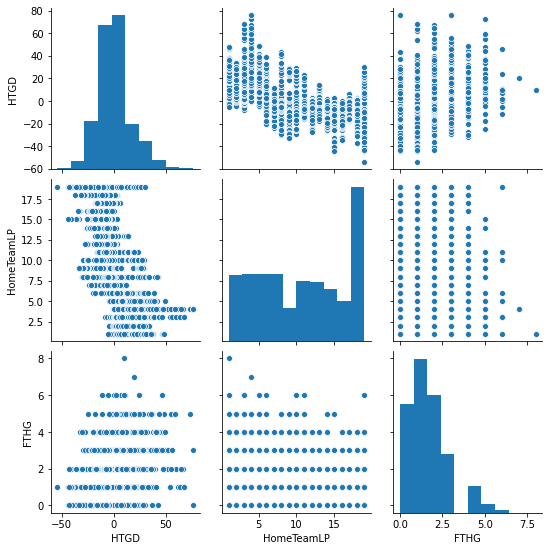

In [27]:
#load final data set
final_data = bc.copy()
# select columns for linear regression analysis
lin_reg_cols = ['Date','HTGD', 'HTFormPtsStr', 'HomeTeamLP', 'FTHG', 'FTR']
# plot the columns to be used
sns.pairplot(final_data[lin_reg_cols])

Based on the above, we notice that the Home team LP (League Position) decreases as Goal Difference increases and that Home Goals are higher when the difference in Goals is smaller (HTGD), which makes sense when the home team wins.

,Date,HTGD,HTFormPtsStr,HomeTeamLP,FTHG,FTR_A,FTR_D,FTR_H
0,2015-08-08,0,MMMM,19.0,0,1,0,0
1,2015-08-08,0,MMMM,3.0,2,0,1,0
2,2015-08-08,0,MMMM,5.0,2,0,1,0
3,2015-08-08,0,MMMM,19.0,4,0,0,1
4,2015-08-08,0,MMMM,7.0,1,0,0,1
...,...,...,...,...,...,...,...,...
283,2020-03-07,7,WWDD,19.0,0,0,1,0
284,2020-03-07,-6,DWWD,7.0,1,0,1,0
285,2020-03-08,8,DWLD,5.0,4,0,0,1
286,2020-03-08,12,DWWD,2.0,2,0,0,1


([<matplotlib.axis.XTick at 0x7fd6362ed220>,
 [Text(0, 1, 'Date'),
  Text(0, 1, 'HTGD'),
  Text(0, 1, 'HTFormPtsStr'),
  Text(0, 1, 'HomeTeamLP'),
  Text(0, 1, 'FTHG'),
  Text(0, 1, 'FTR_A'),
  Text(0, 1, 'FTR_D'),
  Text(0, 1, 'FTR_H')])

([<matplotlib.axis.YTick at 0x7fd6362f2940>,
 [Text(0, 0, 'Date'),
  Text(0, 0, 'HTGD'),
  Text(0, 0, 'HTFormPtsStr'),
  Text(0, 0, 'HomeTeamLP'),
  Text(0, 0, 'FTHG'),
  Text(0, 0, 'FTR_A'),
  Text(0, 0, 'FTR_D'),
  Text(0, 0, 'FTR_H')])

Text(0.5, 1.05, 'Correlation Matrix')

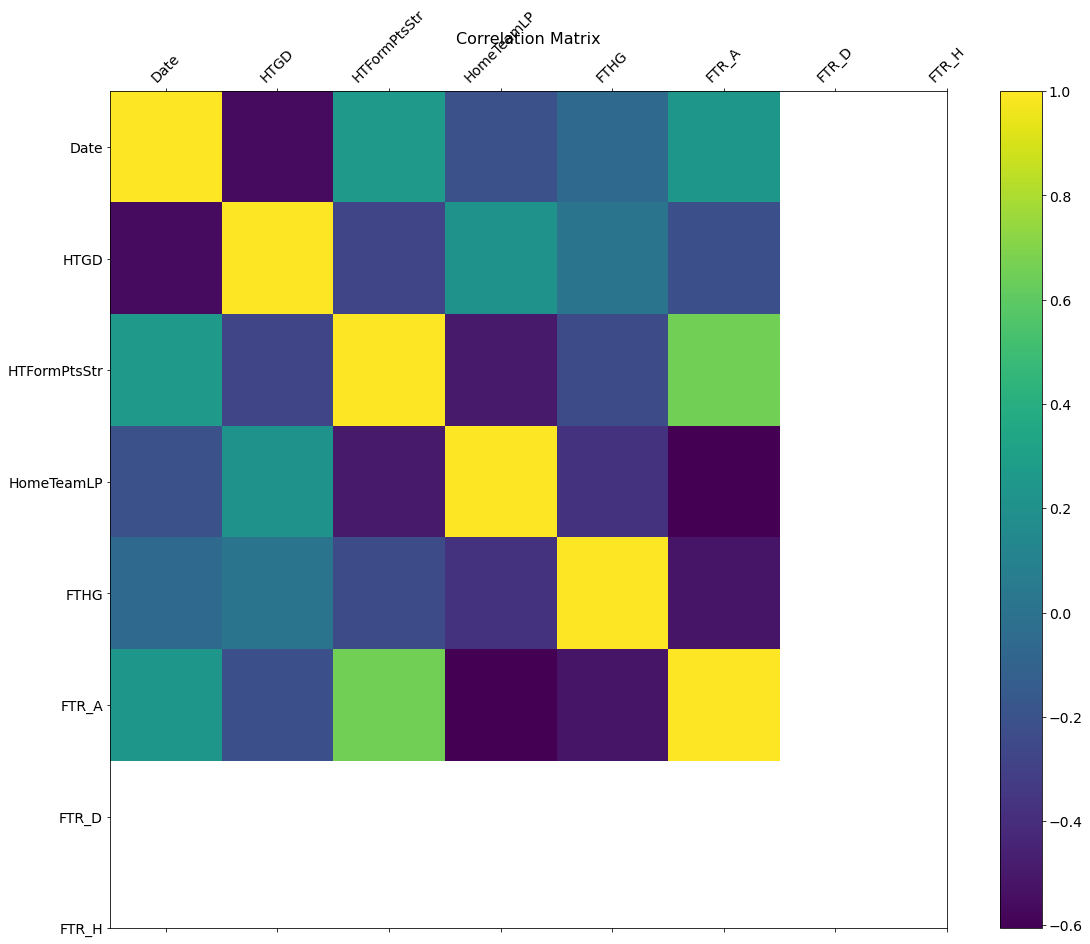

In [28]:
#Create dummy_variables for Final result and for HM1, HM2... etc" and removing Draws and Losses and Missing values for Home team
final_data_FTRdummies=pd.get_dummies(final_data[lin_reg_cols], columns=['FTR'])
final_data_FTRdummies

#Using Pearson Correlation to determine feature importance and build the regression model with the most correlated features
f = plt.figure(figsize=(19, 15))
plt.matshow(final_data_FTRdummies.corr(), fignum=f.number)
plt.xticks(range(final_data_FTRdummies.shape[1]), final_data_FTRdummies.columns, fontsize=14,rotation=45)
plt.yticks(range(final_data_FTRdummies.shape[1]), final_data_FTRdummies.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

LinearRegression()

array([[7.54409965]])

Text(0.5, 1.0, 'EPL Final Result Home Goals Scored vs Home Team League Position - Model One')

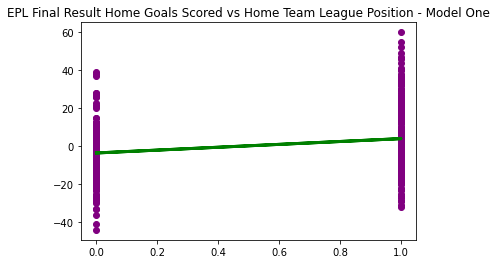

In [29]:
#  We’ll take the following steps:

#1 - Get and reshape the two columns that we want to use in our model: FTR_H and HTGD
X = final_data_FTRdummies['FTR_H']
y = final_data_FTRdummies['HTGD']
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)


#2 - Use the train_test_split function to create our training sets & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#3 - Next up is creating the empty model, then fitting it with our training data. The sklearn package means that this only takes a couple of lines:
lm = LinearRegression()
lm.fit(X_train,y_train)
lm.coef_

#4 - test model by checking predictions and plotting the relationship
predictions = lm.predict(X_test)
plt.scatter(X_test, y_test,  color='purple')
plt.plot(X_test, predictions, color='green', linewidth=3)
plt.title("EPL Final Result Home Goals Scored vs Home Team League Position - Model One")
plt.show()

Text(0.5, 1.0, 'How many points out is each prediction?')

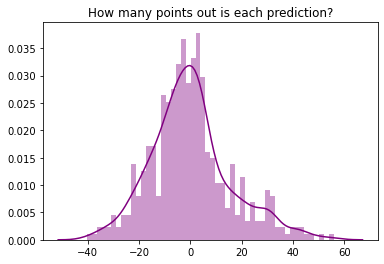

In [30]:
plt.title('How many points out is each prediction?')
sns.distplot((y_test-predictions),bins=50, color = 'purple')

### Interpretation

Linear regression works well in the cases where the is a linear relationship between variables. Given the complexity of the dataset and the clear lack of linear relationships or independence amongst variables, this model is not a good fit for our dataset. Furthermore, the categorical cannot be predicted with this model, and would require further exploration in order to better determine model suitability. We attempt logistic regression in the next section.

# 5.2 Multinomial Logistic regression

In [31]:
y_lr = bc['FTR']
X_lr = bc[cols_in_model]
trans = StandardScaler()
labs = LabelEncoder()
X_lr = trans.fit_transform(X_lr)
y_lr = labs.fit_transform(y_lr.astype('str'))
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

# Train multinomial logistic regression model
mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_lr_train, y_lr_train)

print ("The accuracy for the training data using the logistic regression model is", round(accuracy_score(y_lr_train, mul_lr.predict(X_lr_train))*100,2),'%')
print ("The accuracy for the test data using the logistic regression model is", round(accuracy_score(y_lr_test, mul_lr.predict(X_lr_test))*100,2),'%')

The accuracy for the training data using the logistic regression model is 52.63 %
The accuracy for the test data using the logistic regression model is 56.08 %


### Interpretation
The accuracy of the multinomial logistic regression is 52.63 % for training data and 56.1% for test data. This means that this model would be a relatively good predictor of the outcome of the match. Further exploration will be performed with other models in order to compare which one would fit best our dataset.

# 5.3 Random forest

### Build RF Model

In [32]:
#Define X & Y
y = bc['FTR']
X = bc[cols_in_model]

In [33]:
#Standardization the variables
trans = StandardScaler()
labs = LabelEncoder()
X_rf = trans.fit_transform(X)
y_rf = labs.fit_transform(y.astype('str'))
#Train/Test Split
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [34]:
#Define X, Y for after COVID perid
y_rf_lockdown = post_lockdown['FTR']
X_rf_lockdown = post_lockdown[cols_in_model]
X_rf_lockdown = trans.fit_transform(X_rf_lockdown)
y_rf_lockdown = labs.fit_transform(y_rf_lockdown.astype('str'))

In [35]:
#Define the initial RF model
clf = RandomForestClassifier(random_state = 42)

In [36]:
#Use GridSearch to choose the best set of parameters
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
CV_clf.fit(X_rf_train, y_rf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [37]:
#best set of parameters
CV_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [38]:
clf_best = CV_clf.best_estimator_

In [39]:
#Prediction for both test dataset before and after COVID
y_rf_pred = clf_best.predict(X_rf_test)
y_rf_lockdown_pred = clf_best.predict(X_rf_lockdown)

In [40]:
#Calculate accuracy score for test dataset---before and after COVID
print ("The accuracy for the training data (before COVID) using the RF model is", round(accuracy_score(y_rf_test, y_rf_pred)*100,2),'%')
print ("The accuracy for the test data (after COVID) using the RF model is", round(accuracy_score(y_rf_lockdown, y_rf_lockdown_pred)*100,2),'%')

The accuracy for the training data (before COVID) using the RF model is 53.59 %
The accuracy for the test data (after COVID) using the RF model is 52.63 %


In [41]:
# See what outtcomes are predicted
np.unique(y_rf_pred) # Only away wins (0) and home wins (2)
y_rf_lockdown_pred_unique, y_rf_lockdown_pred_counts = np.unique(y_rf_lockdown_pred, return_counts=True) 
y_rf_lockdown_pred_unique, y_rf_lockdown_pred_counts # Some draws (1) are predicted, however only on 2 occasions

array([0, 2])

(array([0, 1, 2]), array([ 59,   2, 129]))

### Interpretation

The Random Forest Classifier only predicts two outcomes for the result of the game: home win and away win. It may be because there is a stronger features associated with these two outcomes, so the outcome of draw has been absorbed by the model. One possible way to try to improve the accuracy of the model is to just include home win and away win as our prediction outcomes. This will be further explained below.

### Visualisation of Random Forest Model

In [42]:
# Extract the first tree
estimator = clf_best.estimators_[0]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = cols_in_model,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

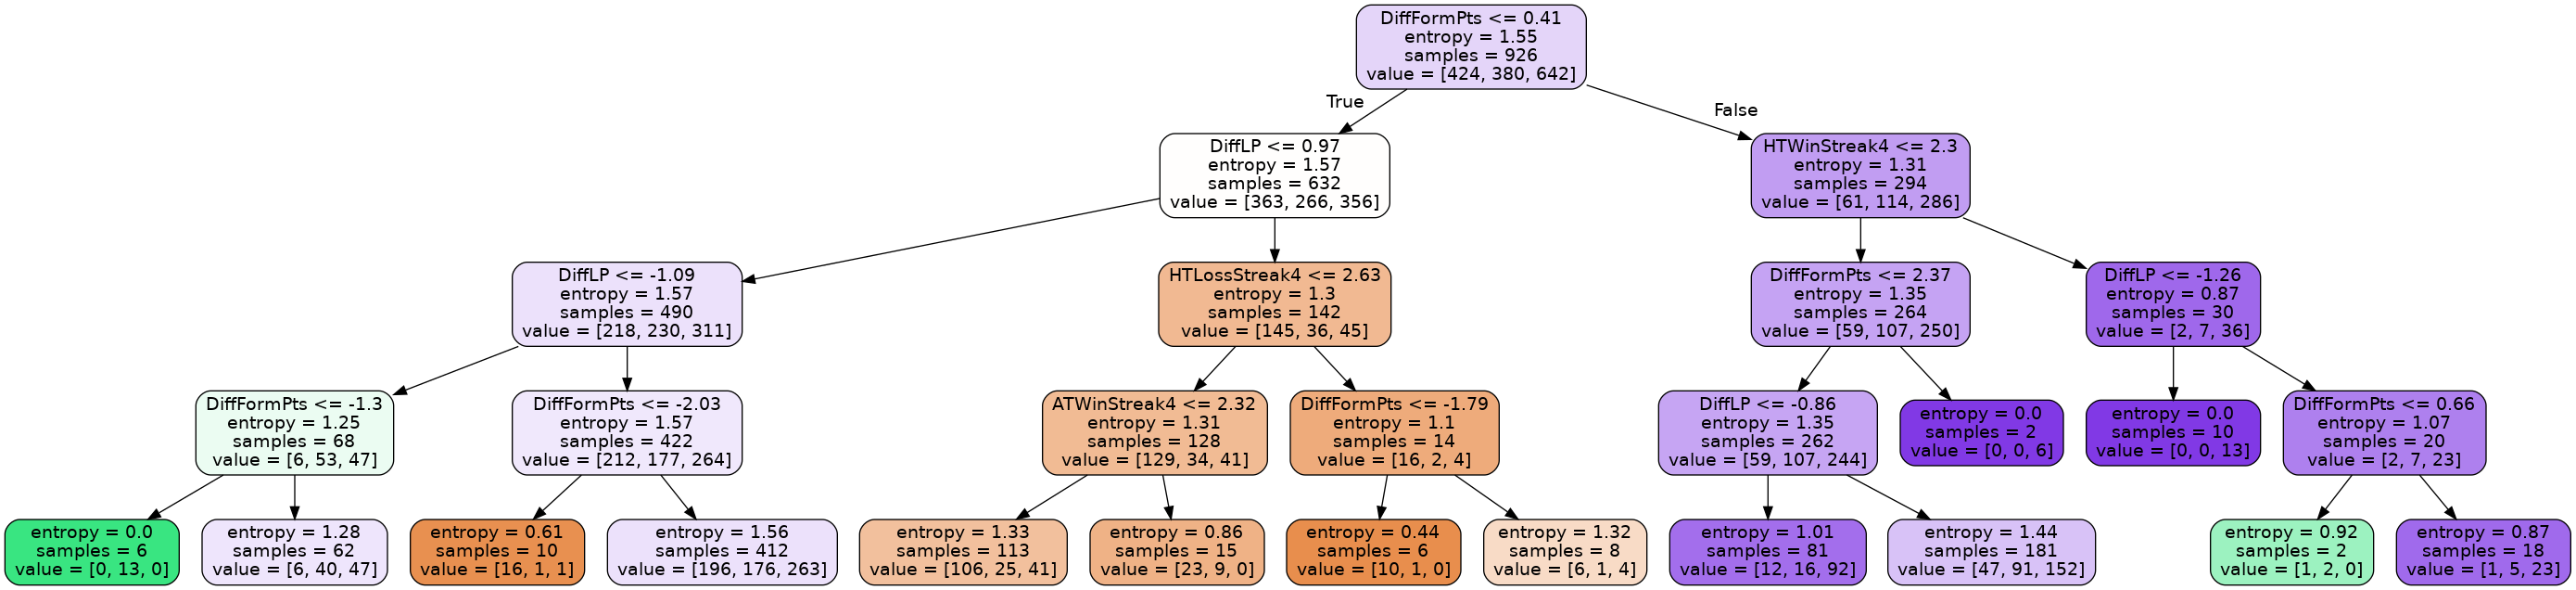

In [43]:
# Use dot file to create a graph
(graph, ) = graph_from_dot_file('/project/tree.dot')
# Write graph to a png file
graph.write_png('tree.png')
# Display in jupyter notebook
Image(filename = '/project/tree.png')

Because the model has built multiple trees, it's hard to identify the decision process. Therefore, we extract the graph of the first tree to understand the decision process. The tree uses ATWinStreak4 as the first predictor to divide the predictor space into two regions. After that, it uses predictors such as difference in points, difference in league position to further split down. 

## 5.4 Support vector classifier (SVC) model

In [44]:
#Define X, Y variables
y_svc = bc['FTR']
X_svc = bc[cols_in_model]

In [45]:
trans = StandardScaler()
labs = LabelEncoder()
X_svc = trans.fit_transform(X_svc)
y_svc = labs.fit_transform(y_svc.astype('str'))
X_svc_train, X_svc_test, y_svc_train, y_svc_test = train_test_split(X_svc, y_svc, test_size=0.2, random_state=42)

In [46]:
y_svc_lockdown = post_lockdown['FTR']
X_svc_lockdown = post_lockdown[cols_in_model]
X_svc_lockdown = trans.fit_transform(X_svc_lockdown)
y_svc_lockdown = labs.fit_transform(y_svc_lockdown.astype('str'))

In [47]:
# hyperparameter tuning of the SVC model
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 10], 'class_weight':[{0: 1/3, 1: 1/3, 2: 1/3}, 'balanced', None], 'gamma': ['scale', 'auto']}
svc = SVC()

# fit the GridSearch using the TRAINING data
grid_searcher = GridSearchCV(svc, parameters, n_jobs=-1, scoring='accuracy')
grid_searcher.fit(X_svc_train, y_svc_train)

#recover the best estimator (best parameters for the SVC, based on the GridSearch)
grid_searcher.best_params_
best_SVC_model = grid_searcher.best_estimator_

y_svc_pred = best_SVC_model.predict(X_svc_test)
y_svc_lockdown_pred = best_SVC_model.predict(X_svc_lockdown)
print ("The accuracy for the training data (Before COVID) using the SVC model is", round(accuracy_score(y_svc_test, y_svc_pred)*100,2),'%')
print ("The accuracy for the test data (After COVID) using the SVC model is", round(accuracy_score(y_svc_lockdown, y_svc_lockdown_pred)*100,2),'%')

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10],
                         'class_weight': [{0: 0.3333333333333333,
                                           1: 0.3333333333333333,
                                           2: 0.3333333333333333},
                                          'balanced', None],
                         'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

{'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}

The accuracy for the training data (Before COVID) using the SVC model is 54.7 %
The accuracy for the test data (After COVID) using the SVC model is 53.16 %


### Interpretation

This model does show a slight improvement in prediction for the test data against the training data.

# 5.5 Naive bayes model

In [48]:
# Create training set and test sets for the model
y_nb = bc['FTR']
X_nb = bc[cols_in_model]
X_nb = trans.fit_transform(X_nb)
y_nb = labs.fit_transform(y_nb.astype('str'))
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(X_nb, y_nb, test_size=0.2, random_state=42)

In [49]:
# import and train Gaussian Naive Bayes

bayes = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=bayes, 
                     param_grid=params_NB, 
                     cv=5,
                     n_jobs=-1,
                     scoring='accuracy') 
gs_NB.fit(X_nb_train, y_nb_train)
gs_NB.best_params_
best_NB_model = gs_NB.best_estimator_
y_nb_pred = best_NB_model.predict(X_nb_test)
accuracy_score(y_nb_test, y_nb_pred)
print ("The model accuracy using naive Bayes for the training data (BC) is", round(accuracy_score(y_nb_test, y_nb_pred)*100,2),'%')


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

{'var_smoothing': 0.8111308307896871}

0.5469613259668509

The model accuracy using naive Bayes for the training data (BC) is 54.7 %


In [50]:
y_nb_lockdown = post_lockdown['FTR']
X_nb_lockdown = post_lockdown[cols_in_model]
X_nb_lockdown = trans.fit_transform(X_nb_lockdown)
y_nb_lockdown = labs.fit_transform(y_nb_lockdown.astype('str'))
y_nb_lockdown_pred = best_NB_model.predict(X_nb_lockdown)
accuracy_score(y_nb_lockdown, y_nb_lockdown_pred)

print ("The model accuracy using naive Bayes for the test data (AC) is", round(accuracy_score(y_nb_lockdown, y_nb_lockdown_pred)*100,2),'%')

0.531578947368421

The model accuracy using naive Bayes for the test data (AC) is 53.16 %


From an initial investigation this model is no better than other models.

# 5.6 Further model exploration

Although the SVC and Naive Bayes models were slightly more accurate in predictions, we have selected the Random Forest model to develop further. This is because, although the Random Forest model is not quite as accurate, it is easier to interpret and work with than the other two models. 

,Variable,Importance,rank
0,DiffLP,0.558035,1.0
1,DiffFormPts,0.307439,2.0
3,ATWinStreak4,0.063910,3.0
2,HTWinStreak4,0.040404,4.0
5,ATLossStreak4,0.015195,5.0
4,HTLossStreak4,0.015018,6.0


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'Importance of features with Random Forest model')

Text(0.5, 0, 'Importance')

Text(0, 0.5, 'Feature')

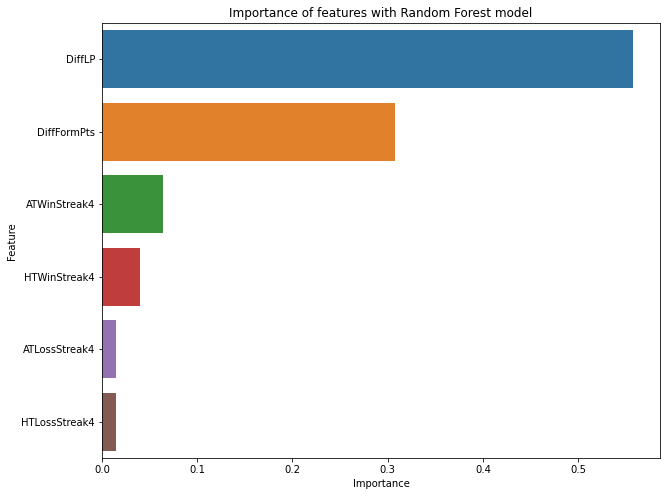

In [51]:
Importance_results = pd.DataFrame({'Variable': pd.Series(cols_in_model), 'Importance':pd.Series(clf_best.feature_importances_)}).sort_values(by = 'Importance', ascending = False)
Importance_results['rank'] = Importance_results['Importance'].rank(ascending = False, method = 'max')
Importance_results

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x= Importance_results['Importance'], y=Importance_results['Variable'])
#Add chart labels
plt.title( 'Importance of features with Random Forest model')
plt.xlabel('Importance')
plt.ylabel('Feature')

This chart shows clearly that the most important variable influencing the result is the difference in league position (from the previous season) for the two teams.

We have carried out a more detailed analysis of the RF results using dimensionality reduction. This simplifies all the data available to plot the results in a 2 dimensional graph (below). This shows how the results are clustered.

There are a few small clusters that are predominantly home wins (H), or away wins (A). There is a large cluster which is a combination of home wins, away wins, and draws.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1808 samples in 0.005s...
[t-SNE] Computed neighbors for 1808 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1808
[t-SNE] Computed conditional probabilities for sample 1808 / 1808
[t-SNE] Mean sigma: 0.199697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.913769
[t-SNE] KL divergence after 300 iterations: 0.568616


<ipython-input-52-ba39953d4b61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-one'] = tsne_results[:,0]


<Figure size 1152x720 with 0 Axes>

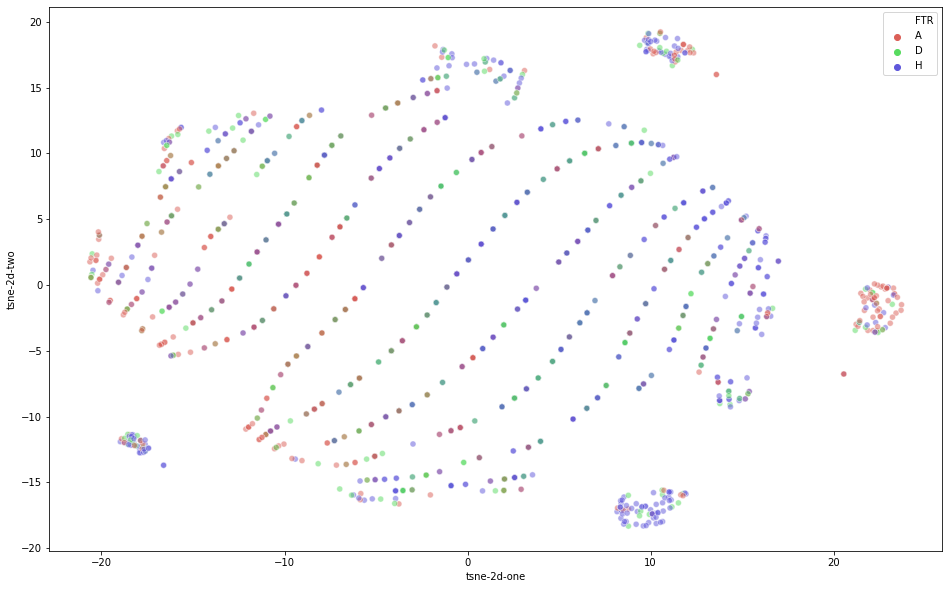

In [52]:
df = bc[cols_in_model + ['FTR']]
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(trans.fit_transform(df[cols_in_model].values))
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="FTR",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.5
)

The model selected from our grid search algorithm above only predicts either home or away wins in the test data, but not draws. Considering around a third of all results are draws, this means that the model's accuracy is limited. However, the reason draws are excluded from the model is that they are evenly distributed amongst the clusters (as illustrated in the chart below). This has led to the model being unable to distinguish between draws and home or away wins, with the model accuracy increasing when draws are excluded from predictions. Draws are predicted in the after COVID model; however there are only 2 matches that are predicted to be draws.

<ipython-input-53-5fa9493966be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-one'] = tsne_results[:,0]


<Figure size 1152x720 with 0 Axes>

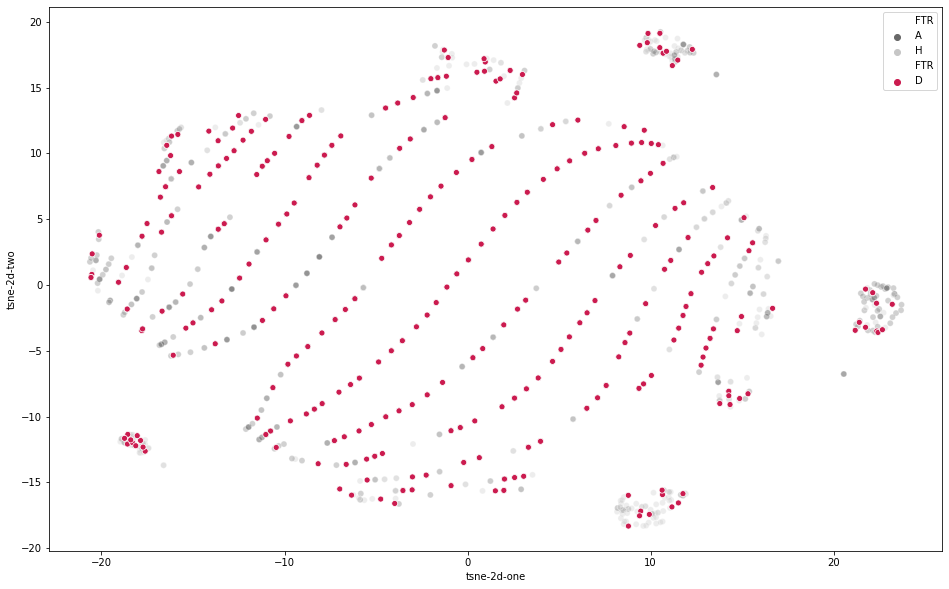

In [53]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df["alpha"] = np.where(df['FTR'] == "D", 1.0, 0.3)
plt.figure(figsize=(16,10))
ax = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="FTR", palette=sns.color_palette("Greys_r", 2),legend="full",
                     data=df[df['alpha'] == 0.3], alpha=0.3)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="FTR",
    palette=sns.color_palette("rocket", 1),
    data=df[df['alpha'] == 1.0],
    legend="full",
    alpha=1.0
)

When excluding draws from the model, the accuracy increases.

In [54]:
bc_no_draws = pd.DataFrame({'y': y_rf_test, 'y_pred': y_rf_pred})
bc_no_draws = bc_no_draws[bc_no_draws['y'] != 1]
print(f'Accuracy of before COVID model with draws removed: {round(accuracy_score(bc_no_draws["y"], bc_no_draws["y_pred"]),2) * 100}%')

ac_no_draws = pd.DataFrame({'y': y_rf_lockdown, 'y_pred': y_rf_lockdown_pred})
ac_no_draws = ac_no_draws[ac_no_draws['y'] != 1]
print(f'Accuracy of after COVID model with draws removed: {round(accuracy_score(ac_no_draws["y"], ac_no_draws["y_pred"]),2) * 100}%')

ac_draws = pd.DataFrame({'y': y_rf_lockdown, 'y_pred': y_rf_lockdown_pred})
ac_draws = ac_draws[ac_draws['y'] == 1]
print(f'Accuracy of after COVID model with draws removed: {round(accuracy_score(ac_draws["y"], ac_draws["y_pred"]),2) * 100}%')

Accuracy of before COVID model with draws removed: 69.0%
Accuracy of after COVID model with draws removed: 66.0%
Accuracy of after COVID model with draws removed: 0.0%


# 6. Limitations

Betting companies will often use predictions for aiming to maximise their profit margins. For this paper, we analyse several variables and the impact that they have on match results, prior to the start of the pandemic, with the aim to prove the inaccuracy of the model for the period of time after the pandemic started.

There are several limitations  that we have been faced with, and these are especially with regards to potential omitted variable,  high correlation amongst existing variables or lack of sufficient observations to be able to obtain statistically significant results.

The outcome of a certain match can likely depend on other factors, such as the amount of  physical training and coaching received by the performing teams, as well as potential changes within the team structure like replacement of team coach, or potential increases in financial remuneration of the players, or even weather conditions. With the current data set that ranges from 2014 - 2020, it is difficult to establish the causal relationship between the existing variables and the outcome of a Home or Away Win. 

# 7. Conclusion

The most suitable model for the data set is Random Forest and this model was selected over other models that have slightly higher accuracy. This was due to the increased interpretability of the RF model over the others, whereby it is possible to quantify the relative contribution of the features to the final model, allowing us to infer importance of features to predicting match results.

There are multiple variables derived from the dataset, with the full list available in **Apendix** for review. However, when analysing model performance, the most relevant variables were chosen based on correlation tests, as well as variable distributions (which can be observed from the **pandas profiling report**). As a next step, we would expand our models and include more variables, to increase accuracy percentage and determine causal links between variables and outcome of the match.

The performed test shows that there is no significant statistical difference between the split of results (home win, away win, draw) before COVID and after COVID under any of the models.

The models could be adapted and used further to enable novel analysis of the results of football matches. That could be by analysing leagues in different countries, or examining the effect of changes on other variables such as total goals scored, average home or away goals, or more granular data such as the number of fouls or corners in a match.

It could also involve looking at the effect of other changes in rules or playing conditions, for example the introduction of VAR (video assistant referee) technology to help the referee make decisions, which many observers consider has changed the game signficantly.

### Wordcount

In [55]:
#word count code
Appendix_TableOfContents_wordcount = 708
import io
from nbformat import current
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count-Appendix_TableOfContents_wordcount
nb_word_count('/project/MSIN0143_2020_GROUP_N2.ipynb') 


2180

# I. Appendix

### Feature list and definition:

* **HTGD** (Home Team Goal Difference) = represents the Home Team's cumulative number of goals scored - goals conceded 
* **ATGD** (Home Team Goal Difference) = represents the Away Team's cumulative number of goals scored - goals conceded 
* **DiffFormPts** = represents the difference between Home Team's and Away Team's performance in the last 4 games. For example, Home Team won the last 4 games (denoated as "WWWW" string in the data set) and Away Team only won 2 games in the last 4 games (denoted as "LWWL" string in the data set). We attribute points based on the official scoring system in football, which is W (Win) = 3, L (Loss) = 0 and D (Draw) = 1. Therefore, the difference would then be 12 (4 x 3 won matches) - 8 (4 x 2 won matches) = 4 from the perspective of the Home Team.
* **DiffPts** = represents the difference of the cumulative match points sum between Home Team and Away Team from the start of the season until today
* **HTWinStreak4** (binary) = states whether the Home Team has won the last 4 games in a row  
* **HTWinStreak3** (binary) = states whether the Home Team has won the last 3 games in a row  
* **ATWinStreak4** (binary) = states whether the Away Team has won the last 4 games in a row 
* **ATWinStreak3** (binary) = states whether the Away Team has won the last 3 games in a row 
* **HTLossStreak4** (binary) = states whether the Home Team has lost the last 4 games in a row 
* **HTLossStreak3** (binary) = states whether the Home Team has lost the last 3 games in a row 
* **ATLossStreak4** (binary) = states whether the Away Team has lost the last 4 games in a row 
* **ATLossStreak3** (binary) = states whether the Away Team has lost the last 3 games in a row 
* **DiffLP** = represents the difference between Home Team's and Away Team's last year standing. For example, Home Team ranked second last year, whereas Away Team ranked 16th. The difference would then be 2 - 16 = -14 from the perspective of the Home Team.

### Final columns for dataset

* Date = Match date (dd/mm/yy)
* HomeTeam = Name of home team
* AwayTeam = Name of away team
* FHTG = Full time home team goals
* FTAG = Full time home team goals
* HTGS = Home team goals scored
* ATGS = Away team goals scored
* HTGC = Home team goals conceded 
* ATGC = Away team goals conceded 
* HTP = Home team cumulative points
* ATP = Away team cumulative points
* HM1 = Performance (D, W, L or M = if not played yet) of home team of previous game
* HM2 = Performance (D, W, L or M = if not played yet) of home team of second last game
* HM3 = Performance (D, W, L or M = if not played yet) of home team of third last game
* HM4 = Performance (D, W, L or M = if not played yet) of home team of fourth last game
* AM1 = Performance (D, W, L or M = if not played yet) of away team of previous game
* AM2 = Performance (D, W, L or M = if not played yet) of away team of second last game
* AM3 = Performance (D, W, L or M = if not played yet) of away team of third last game
* AM4 = Performance (D, W, L or M = if not played yet) of away team of fourth last game
* HomeTeamLP = Home team's last year standing
* AwayTeamLP = Away team's last year standing
* HTFormPtsStr = Home team's string summarized performance of the four last games (e.g. "DDWW")
* ATFormPtsStr = Away team's string summarized performance of the four last games (e.g. "DDWW")